In [1]:
from torch import optim
import torch
from text_model import TextCNN , TextRNN
from create_wordvec import make_test_dataLodaer , make_val_dataLodaer
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
EMBEDDING_DIM = 300
NUM_OF_CLASS = 5
MODEL_USE_DATA_KIND = 0
MODEL_NAME = "CNN"

testDataLoader , vocab_size , vocab_vec = make_test_dataLodaer(train_dataset_kind = MODEL_USE_DATA_KIND, batch_size=64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = f'../model_param/{MODEL_USE_DATA_KIND}-{MODEL_NAME}_42B_300d_glove.pth'
# RNN_MODEL_PATH = '../model_param/RNN_42B_300d_glove.pth'

==========Load data to batch
==========start create origin word embedding
==========Load test data finished


In [5]:
cnn_model = TextCNN(vocab_size=vocab_size , embedding_dim=EMBEDDING_DIM , num_of_class=NUM_OF_CLASS , embedding_vectors=vocab_vec , device=device)
checkpoint = torch.load(MODEL_PATH)
cnn_model.load_state_dict(checkpoint['model'])
cnn_model.eval()

TextCNN(
  (embed): Embedding(16455, 300)
  (convs): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(3, 300), stride=(1, 1))
    (1): Conv2d(1, 64, kernel_size=(4, 300), stride=(1, 1))
    (2): Conv2d(1, 64, kernel_size=(5, 300), stride=(1, 1))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (classifier): Linear(in_features=192, out_features=5, bias=True)
)

### CNN 验证

In [11]:
valDataLoader , _ , _ = make_val_dataLodaer(train_dataset_kind = MODEL_USE_DATA_KIND , batch_size=64)
valResult = []
label = []
for batch in tqdm(valDataLoader):
    x , y , _ = batch
    # x = x.to(device)
    logits = cnn_model(x.to(device))
    _ , predi = torch.max(logits , dim=1)
    valResult.extend(predi.tolist())
    label.extend(y.tolist())

==========Load data to batch
==========start create origin word embedding
==========Load test data finished


100%|██████████| 157/157 [00:00<00:00, 333.33it/s]


In [12]:
import numpy as np
(np.array(valResult) == np.array(label)).sum() / len(label)

0.2135

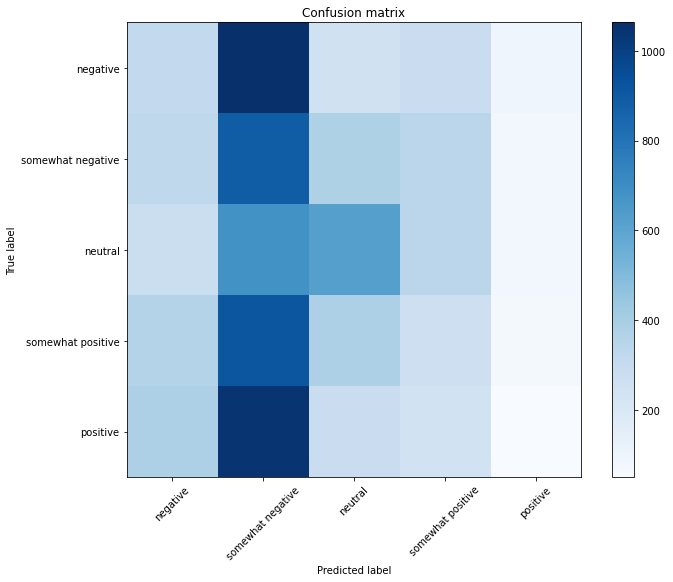

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(label , valResult)
classes = ['negative','somewhat negative','neutral','somewhat positive','positive']

# 绘制混淆矩阵
plt.figure(figsize=(10,8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### CNN 预测

In [9]:
result = []
for batch in tqdm(testDataLoader):
    x , _ = batch
    x = x.to(device)
    logits = cnn_model(x)
    _ , predi = torch.max(logits , dim=1)
    result.extend(predi.tolist())


100%|██████████| 1036/1036 [00:02<00:00, 466.67it/s]


In [10]:
import pandas as pd
from datetime import datetime
df = pd.read_csv('../data/test.tsv' , sep='\t')
df['Sentiment'] = result
df = df[['PhraseId' , 'Sentiment']]
now = datetime.now().strftime('%Y-%m-%d %H:%M')
df.to_csv(f'output/{MODEL_USE_DATA_KIND}-{MODEL_NAME}-submit.csv', index=None)

### RNN 验证

In [22]:
MODEL_PATH = f'../model_param/{MODEL_USE_DATA_KIND}-RNN_42B_300d_glove.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

rnn_model = TextRNN(vocab_size=vocab_size , embedding_dim=EMBEDDING_DIM , hidden_size=192 , num_of_class=NUM_OF_CLASS , device=device)
checkpoint = torch.load(MODEL_PATH)
rnn_model.load_state_dict(checkpoint['model'])
rnn_model.eval()

TextRNN(
  (embed): Embedding(18228, 300)
  (dropout): Dropout(p=0.2, inplace=False)
  (rnn): RNN(300, 192, batch_first=True)
  (classifier): Linear(in_features=192, out_features=5, bias=True)
)

In [23]:
valDataLoader , _ , _ = make_val_dataLodaer(train_dataset_kind = MODEL_USE_DATA_KIND , batch_size=64)
valResult = []
label = []
for batch in tqdm(valDataLoader):
    x , y , _ = batch
    # x = x.to(device)
    logits = rnn_model(x.to(device))
    _ , predi = torch.max(logits , dim=1)
    valResult.extend(predi.tolist())
    label.extend(y.tolist())

==========Load data to batch
==========start create origin word embedding
==========Load test data finished


100%|██████████| 157/157 [00:00<00:00, 372.05it/s]


In [8]:
import numpy as np
(np.array(valResult) == np.array(label)).sum() / len(label)

0.22

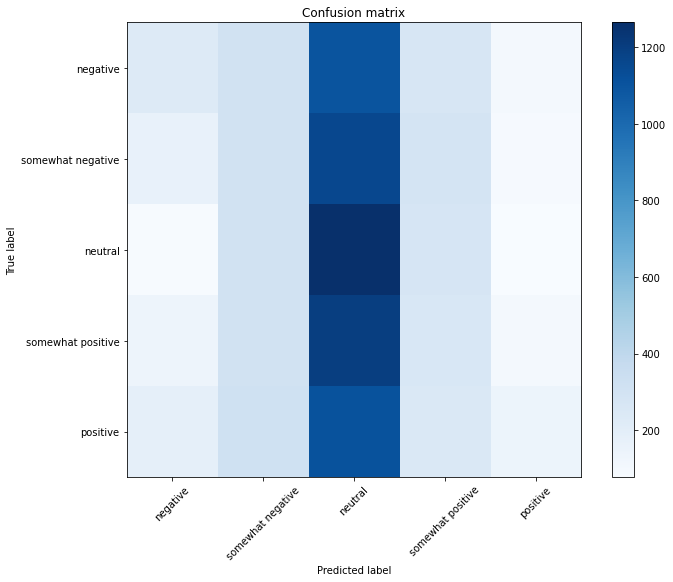

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(label , valResult)
classes = ['negative','somewhat negative','neutral','somewhat positive','positive']

# 绘制混淆矩阵
plt.figure(figsize=(10,8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### RNN 预测

In [24]:
result = []
for batch in tqdm(testDataLoader):
    x , _ = batch
    x = x.to(device)
    logits = rnn_model(x)
    _ , predi = torch.max(logits , dim=1)
    result.extend(predi.tolist())

100%|██████████| 1036/1036 [00:02<00:00, 458.41it/s]


In [25]:
import pandas as pd
from datetime import datetime
df = pd.read_csv('../data/test.tsv' , sep='\t')
df['Sentiment'] = result
df = df[['PhraseId' , 'Sentiment']]
now = datetime.now().strftime('%Y-%m-%d %H:%M')
df.to_csv(f'output/{MODEL_USE_DATA_KIND}-RNN-submit.csv', index=None)

### LSTM 验证

In [14]:
MODEL_PATH = f'../model_param/{MODEL_USE_DATA_KIND}-LSTM_42B_300d_glove.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

rnn_model = TextRNN(vocab_size=vocab_size , embedding_dim=EMBEDDING_DIM , rnn_type="LSTM" , hidden_size=192 , num_of_class=NUM_OF_CLASS , device=device)
checkpoint = torch.load(MODEL_PATH)
rnn_model.load_state_dict(checkpoint['model'])
rnn_model.eval()

TextRNN(
  (embed): Embedding(18228, 300)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(300, 192, batch_first=True)
  (classifier): Linear(in_features=192, out_features=5, bias=True)
)

In [16]:
valDataLoader , _ , _ = make_val_dataLodaer(train_dataset_kind = MODEL_USE_DATA_KIND , batch_size=64)
valResult = []
label = []
for batch in tqdm(valDataLoader):
    x , y , _ = batch
    # x = x.to(device)
    logits = rnn_model(x.to(device))
    _ , predi = torch.max(logits , dim=1)
    valResult.extend(predi.tolist())
    label.extend(y.tolist())

==========Load data to batch
==========start create origin word embedding
==========Load test data finished


100%|██████████| 157/157 [00:01<00:00, 105.72it/s]


In [17]:
import numpy as np
(np.array(valResult) == np.array(label)).sum() / len(label)

0.2144

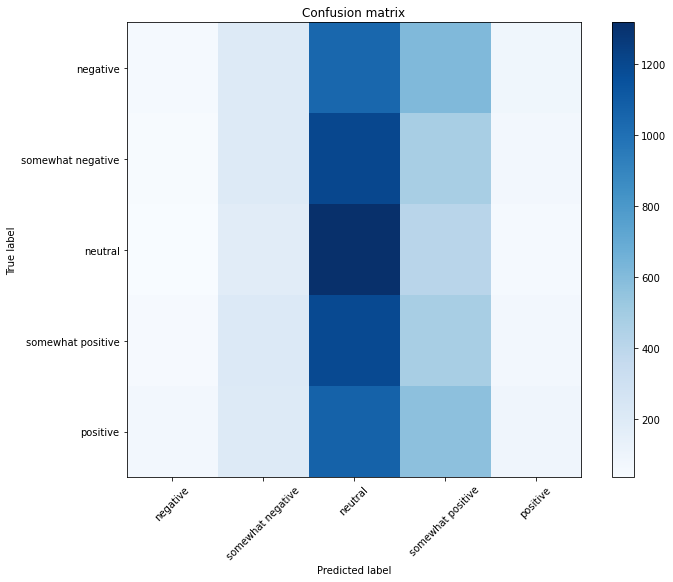

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(label , valResult)
classes = ['negative','somewhat negative','neutral','somewhat positive','positive']

# 绘制混淆矩阵
plt.figure(figsize=(10,8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### LSTM 预测

In [20]:
result = []
for batch in tqdm(testDataLoader):
    x , _ = batch
    x = x.to(device)
    logits = rnn_model(x)
    _ , predi = torch.max(logits , dim=1)
    result.extend(predi.tolist())


import pandas as pd
from datetime import datetime
df = pd.read_csv('../data/test.tsv' , sep='\t')
df['Sentiment'] = result
df = df[['PhraseId' , 'Sentiment']]
now = datetime.now().strftime('%Y-%m-%d %H:%M')
df.to_csv(f'output/{MODEL_USE_DATA_KIND}-LSTM-submit.csv', index=None)

100%|██████████| 1036/1036 [00:07<00:00, 138.82it/s]


### Bi-LSTM 验证


In [26]:
MODEL_PATH = f'../model_param/{MODEL_USE_DATA_KIND}-Bi-LSTM_42B_300d_glove.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

rnn_model = TextRNN(vocab_size=vocab_size , embedding_dim=EMBEDDING_DIM , rnn_type="Bi-LSTM" , hidden_size=192 , num_of_class=NUM_OF_CLASS , device=device)
checkpoint = torch.load(MODEL_PATH)
rnn_model.load_state_dict(checkpoint['model'])
rnn_model.eval()

TextRNN(
  (embed): Embedding(18228, 300)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(300, 192, batch_first=True, bidirectional=True)
  (classifier): Linear(in_features=384, out_features=5, bias=True)
)

In [28]:
valDataLoader , _ , _ = make_val_dataLodaer(train_dataset_kind = MODEL_USE_DATA_KIND , batch_size=64)
valResult = []
label = []
for batch in tqdm(valDataLoader):
    x , y , _ = batch
    # x = x.to(device)
    logits = rnn_model(x.to(device))
    _ , predi = torch.max(logits , dim=1)
    valResult.extend(predi.tolist())
    label.extend(y.tolist())

import numpy as np
(np.array(valResult) == np.array(label)).sum() / len(label)

==========Load data to batch
==========start create origin word embedding
==========Load test data finished


100%|██████████| 157/157 [00:02<00:00, 65.12it/s]


0.2157

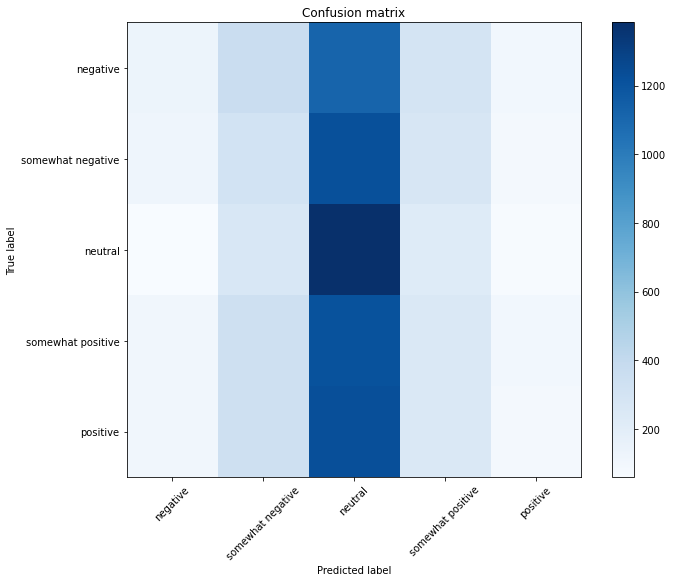

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(label , valResult)
classes = ['negative','somewhat negative','neutral','somewhat positive','positive']

# 绘制混淆矩阵
plt.figure(figsize=(10,8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Bi-LSTM 预测

In [31]:
result = []
for batch in tqdm(testDataLoader):
    x , _ = batch
    x = x.to(device)
    logits = rnn_model(x)
    _ , predi = torch.max(logits , dim=1)
    result.extend(predi.tolist())


import pandas as pd
from datetime import datetime
df = pd.read_csv('../data/test.tsv' , sep='\t')
df['Sentiment'] = result
df = df[['PhraseId' , 'Sentiment']]
now = datetime.now().strftime('%Y-%m-%d %H:%M')
df.to_csv(f'output/{MODEL_USE_DATA_KIND}-Bi-LSTM-submit.csv', index=None)

100%|██████████| 1036/1036 [00:13<00:00, 76.43it/s]
